In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import helper_funcs
import grf_classes

/var/folders/lm/fytp98593278937y432535m40000gn/T/ipykernel_81935/2352191391.py:6: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  mask = hp.fitsfunc.read_map(path, verbose=True)


10.0
8385
0 90176
768 129


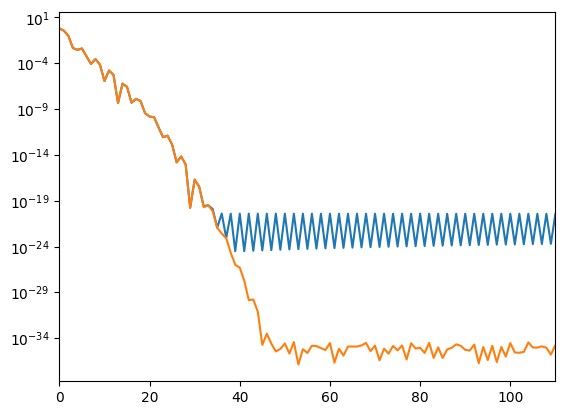

[-1.67382395e-06 -1.52930099e-06 -1.52930099e-06 ... -1.52930099e-06
 -1.52930099e-06 -1.67382395e-06]


In [30]:
area = 10000
nside = 256
lmax = 3*nside-1
thres = 10**-10
path = "circular_{:d}sqd_nside{:d}.fits".format(area, nside)
mask = hp.fitsfunc.read_map(path, verbose=True)
mask_cl = hp.sphtfunc.anafast(mask)
sigma_res = np.deg2rad(10)
#sigma_res = 2**2 / 12 * np.log10(np.e)
print(np.rad2deg(sigma_res))
smoothed_mask = hp.sphtfunc.smoothing(mask, sigma=np.abs(sigma_res),iter=50,use_pixel_weights=True)
wlm_lmax = hp.sphtfunc.map2alm(smoothed_mask, lmax=lmax)


smoothed_alm_old = hp.sphtfunc.map2alm(smoothed_mask, lmax=nside/2)
print(len(smoothed_alm_old))
wl_old = hp.sphtfunc.alm2cl(smoothed_alm_old)
dummy_alm = np.zeros_like(wlm_lmax)
lmax_100 = hp.sphtfunc.Alm.getlmax(len(smoothed_alm_old))
idx_1 = hp.sphtfunc.Alm.getidx(lmax,0,0)
idx_2 = hp.sphtfunc.Alm.getidx(lmax,lmax_100,lmax_100)
print(idx_1, idx_2)
#dummy_alm[idx_1:idx_2+1] = smoothed_alm_old
#smoothed_alm = dummy_alm
wl = hp.sphtfunc.alm2cl(wlm_lmax)

print(len(wl),len(wl_old))
plt.figure()
plt.plot(wl)
plt.plot(wl_old)
plt.xlim(0, 110)
plt.yscale("log")
plt.show()

smoothed_cl = hp.sphtfunc.anafast(smoothed_mask)
smoothed_mask = hp.sphtfunc.alm2map(wlm_lmax, nside=nside)
smoothed_mask_old = hp.sphtfunc.alm2map(smoothed_alm_old, nside=nside)
print(smoothed_mask-smoothed_mask_old)




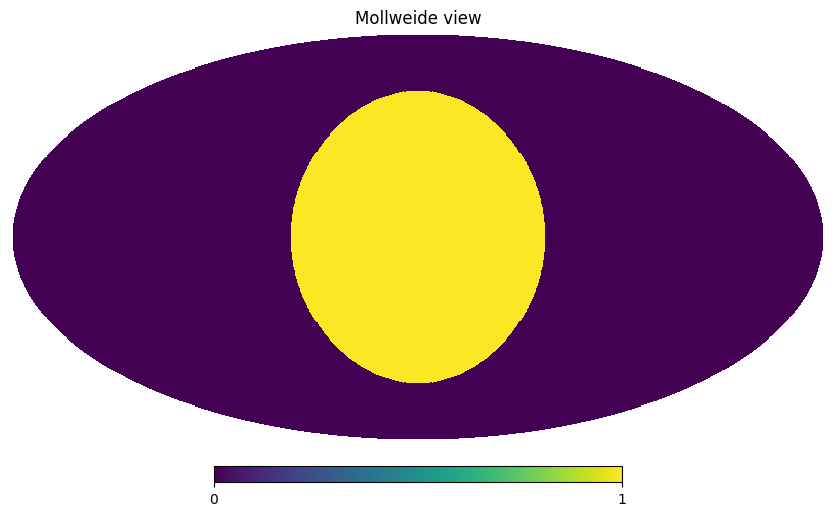

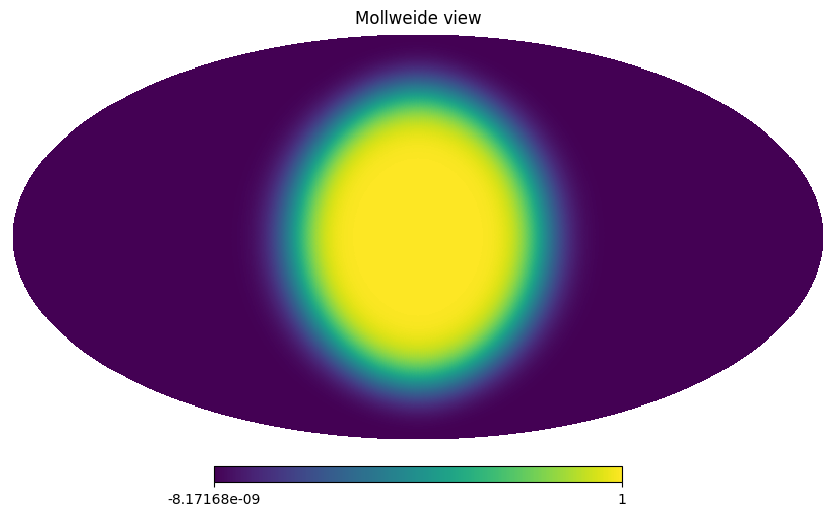

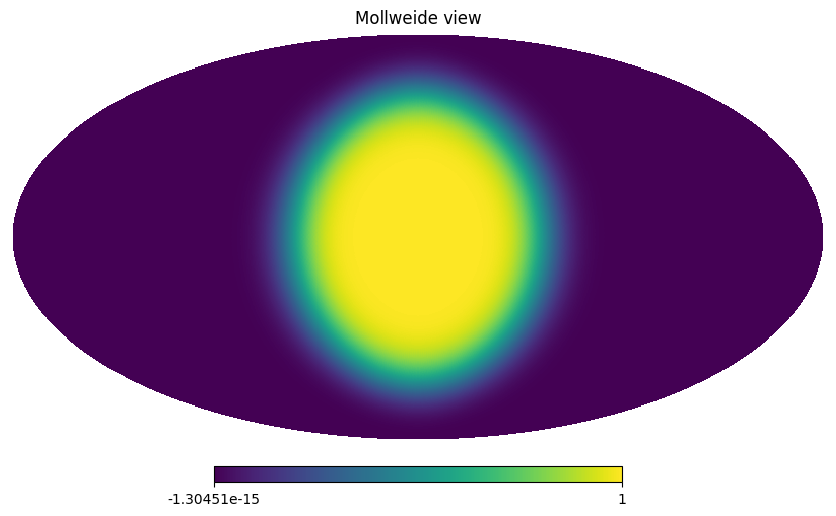

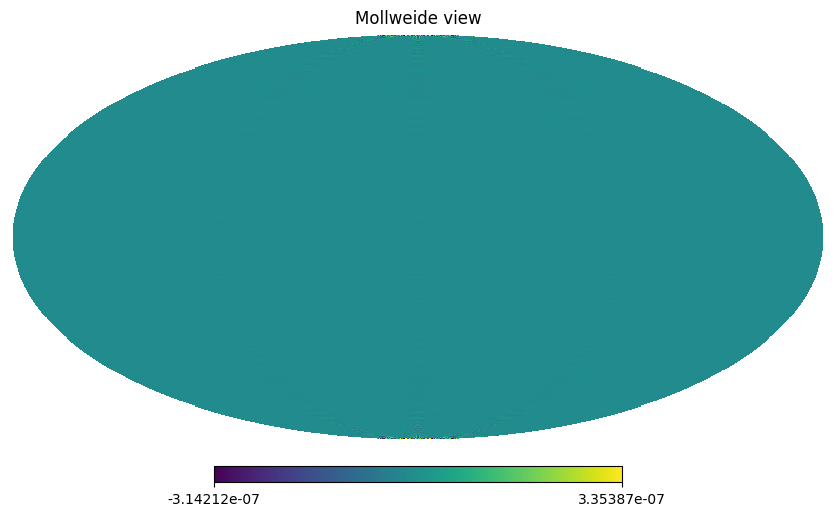

In [31]:
hp.mollview(mask)
hp.mollview(smoothed_mask)
hp.mollview(smoothed_mask_old)
hp.mollview(smoothed_mask-smoothed_mask_old)
plt.show()

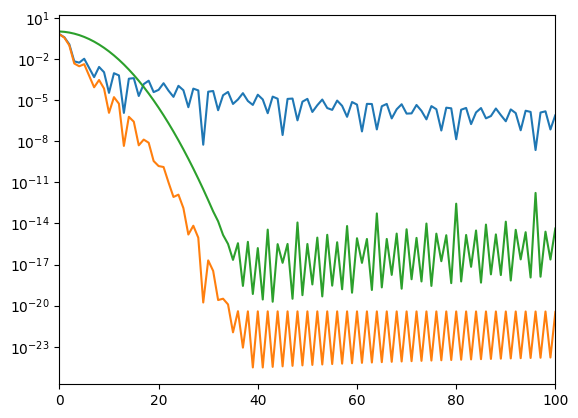

In [8]:

plt.figure()
plt.plot(mask_cl)
plt.plot(smoothed_cl)
plt.plot(smoothed_cl/mask_cl)
plt.xlim(0,100)
plt.yscale('log')
plt.show()

In [37]:
smooth_lm = 30
wlm = hp.sphtfunc.map2alm(mask)



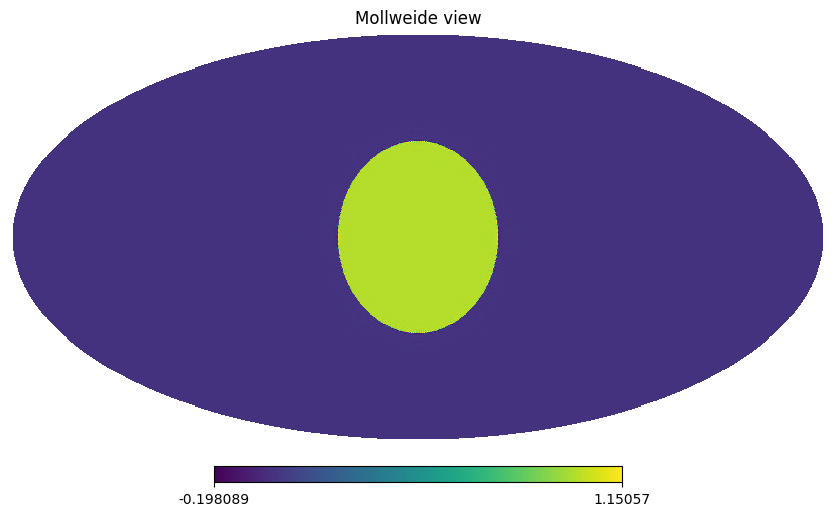

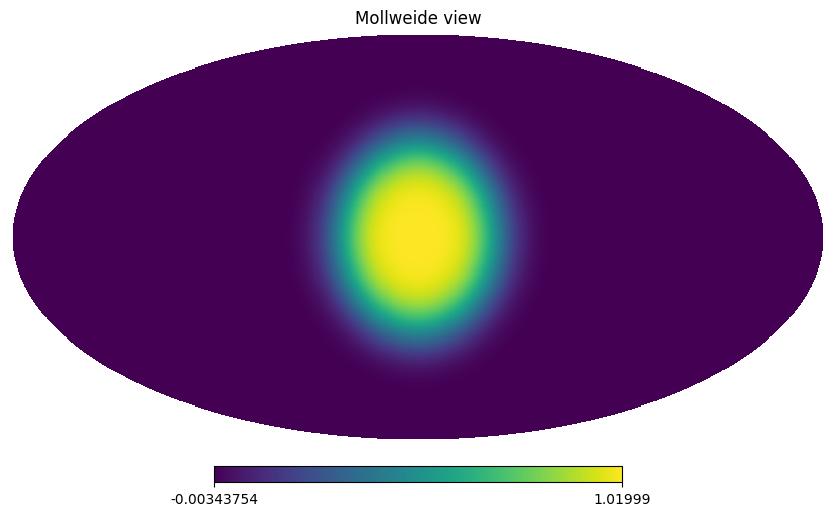

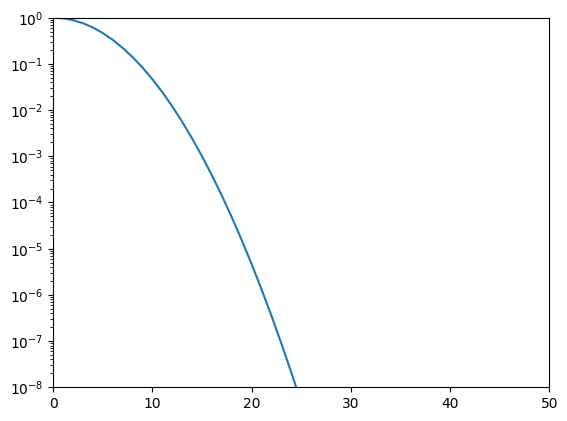

In [41]:
def smooth_gauss(l,l_smooth):
    sigma2 = l_smooth**2 / 12 * np.log10(np.e)
    return np.exp(-l**2/(2*sigma2))

def smooth_alm(alm,l_smooth,lmax):
    l_array = [np.arange(i,lmax+1) for i in range(lmax+1)]
    l_array = np.concatenate(l_array, axis=0 )
    smoothing_arr = smooth_gauss(l_array,l_smooth)
    smoothing_arr[l_array > 3*l_smooth] = 0
    return alm * smoothing_arr

smooth_wlm = smooth_alm(wlm,smooth_lm,lmax)
mask = hp.sphtfunc.alm2map(wlm,nside)
mask_smooth = hp.sphtfunc.alm2map(smooth_wlm,nside)

hp.mollview(mask)
hp.mollview(mask_smooth)

cl = hp.sphtfunc.alm2cl(wlm)
cl_sm = hp.sphtfunc.alm2cl(smooth_wlm)

plt.figure()
plt.plot(cl_sm/cl)
plt.xlim(0,50)
plt.ylim(10**-8,1)
plt.yscale('log')
plt.show()


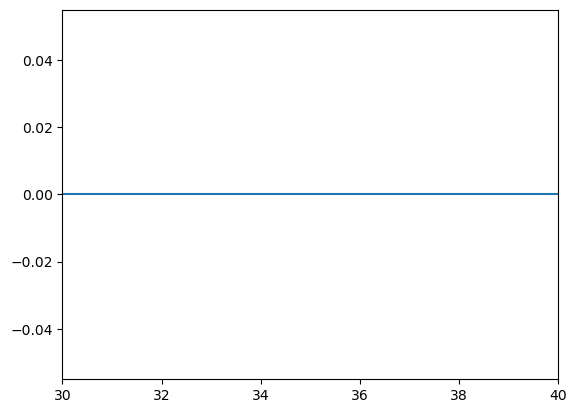

In [8]:
from scipy.special import eval_legendre
LM = np.arange(smooth_lm,lmax+1)
norms = []
for lm in LM:

    norm_l = np.arange(lm + 1)
    legendres = lambda t_in_rad: eval_legendre(norm_l, np.cos(t_in_rad))
    # TODO: check whether this sum needs to be done after the integration as well (even possible?)
    norm = (
        lambda t_in_rad: 1
        / np.sum((2 * norm_l + 1) * legendres(t_in_rad) * cl_sm[: lm + 1])
        / (2 * np.pi)
    )
    norms.append(norm(5*np.pi/180))
rel_error = [(norms[i]-norms[-1])/norms[-1] for i in range(len(norms))]
rel_error_rec = [(1/norms[i] - 1/norms[-1]) for i in range(len(norms))]
plt.figure()
plt.plot(LM,rel_error_rec)
#plt.yscale('log')
plt.xlim(30,40)
plt.show()

lmax has been set to 767.
Loaded C_l with lmax = 767


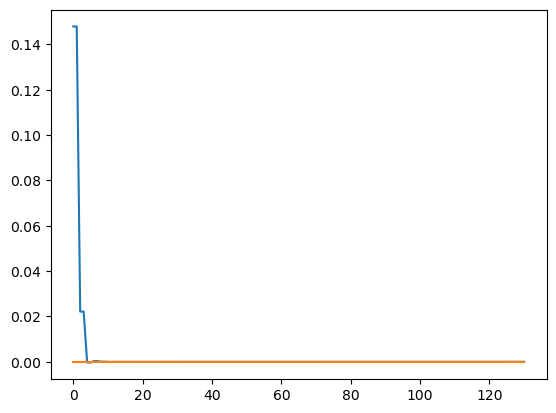

In [9]:
def sum_testing():
    import wpm_funcs
    from cov_setup import Cov

    exact_lm = 30
    new_cov = Cov(
        exact_lm,
        [2],
        circmaskattr=(4000, 256),
        clpath="Cl_3x2pt_kids55.txt",
        sigma_e="default",
        l_smooth="auto",
    )
    l1,l2,m1,m2 = 10,10,10,10
    M = m1-m2
    buffer_lmax = exact_lm + 100
    ell, wignersp,wignersm = wpm_funcs.prepare_wigners(2, l1,l2,m1,m2, buffer_lmax)
    wlppM = wpm_funcs.get_wlm_l(new_cov.wlm_lmax, M, new_cov.lmax, ell)
    factors = wpm_funcs.w_factor(ell, l1, l2)
    sums = np.cumsum(wlppM)
    plt.figure()
    #plt.plot(ell,wlppM)
    #plt.plot(ell,sums)
    #plt.plot(ell,new_cov.wl[:buffer_lmax+1])
    plt.plot(ell, np.sum(wignersp * wlppM * factors).real-np.cumsum(wignersp * wlppM * factors).real)
    plt.plot(ell, np.sum(wignersp * wlppM * factors).imag-np.cumsum(wignersp * wlppM * factors).imag)
    #plt.plot(ell, np.abs(wignersm * wlppM * factors))
    
    plt.show()


sum_testing()

lmax has been set to 767.
Loaded C_l with lmax = 767


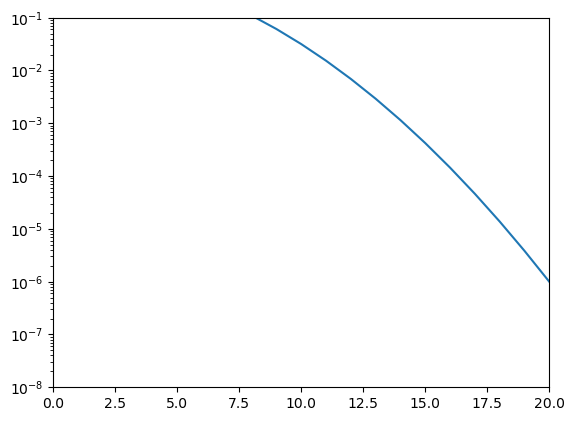

In [20]:
def smooth_cl(l, l_smooth):
    sigma2 = l_smooth**2 / 12 * np.log10(np.e)
    return np.exp(-(l**2) / (2 * sigma2))
cl = grf_classes.TheoryCl(lmax,clpath="Cl_3x2pt_kids55.txt")
ell = np.arange(lmax+1)
l_smooth = 20
plt.figure()
#plt.plot(ell[2:],cl.ee[2:])
#plt.plot(ell[2:],cl.ee[2:]*smooth_cl(ell,l_smooth)[2:])
plt.plot(ell[2:],smooth_cl(ell,l_smooth)[2:])
plt.yscale('log')
plt.xlim(0,l_smooth)
plt.ylim(1e-8,1e-1)
plt.show()